# Summary

Demonstrates using tensorflow_datasets to access mnist data and build a premade TF DNN Estimator to do image classification

Most of this works, but I didn't quite figure out all the details regarding how to invoke a saved and served Estimator. Based on guidance [here](https://medium.com/tensorflow/standardizing-on-keras-guidance-on-high-level-apis-in-tensorflow-2-0-bad2b04c819a), I stopped banging at this and pivoted to figuring out how to use a tf.keras version of the same idea, as it seemed a little more approachable for what I wanted.  Notes below discuss where I left off if I come back to this...

In [77]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tempfile

import matplotlib.pyplot as plt

# Avoid double error messages from the tf logger
tf.get_logger().propagate=False

from skopt import Optimizer
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_evaluations, plot_objective, plot_regret

## Load Data

tf.Estimator wants an input_fn that provides:
````
(dict_of_feature_tensors, label_tensor)
````
where the dict_of_feature_tensors is of format:
````
feature_dict = {
    feature0_name: feature0_tensor,
    feature1_name: feature1_tensor, 
    ...
}
````
Each entry in the feature_dict can be a single feature's tensor, or could be (I think?) a group of similar tensors (eg: tensors that are of the same type, such as all numerical tensors).  We see this sort of grouping when using tfds.load("iris"), where, the four numerical features can all be in a single "features" entry (with four columns).

When feeding data to a tf.Estimator through the input_fn, the fn must either provide a batch of data in the tuple format above, or must be a dataset that contains data in that format.

tfds.load() returns data in a dataset formatted slightly different from above.  If `as_supervised==True` then it has data of format:
````
(features_tensor, label_tensor)
````
Where all features (in the case of mnist, the 28x28 image) are in a single tensor rather than a dict of tensors.  If `as_supervised==False` then data is of format:
````
dict_of_tensors
````
where the dict of tensors is similar to features_dict with features optionally under their own key, but includes en entry for the labels as well `{label":label_tensor}`

In both cases, we need to remap the dataset to provide the desired input format for an Estimator.

In [2]:
FEATURES_NAME = "image"
LABELS_NAME = "label"
CLASS_NAMES = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [17]:
def input_fn(split="train", as_supervised=True, batch_size=32, shuffle_buffer_size=256):
    ds = tfds.load("mnist", split=split, as_supervised=as_supervised)
    
    if as_supervised:
        def parse_record(features, labels):
            return ({FEATURES_NAME: features}, labels)
    else:
        def parse_record(record):
                return ({FEATURES_NAME: record[FEATURES_NAME]}, record[LABELS_NAME])
    
    ds = ds.map(parse_record)
    ds = ds.shuffle(shuffle_buffer_size)
    # Could add additional ops, or do them on our own
#     ds = ds.repeat(n_repeats_of_data)
    ds = ds.batch(batch_size)  # Batch after shuffling so your batches are non-homogenius.
    return ds

To inspect data in the dataset, you can iterate through it.  
Each "row" will be a tuple of the format mentioned above for Estimators
Use batch_size=1 here to count the total number of images  
**Is there a better way?**

In [39]:
ds = input_fn(split="train", batch_size=1)

for i, x in enumerate(ds):
    # printing each row is a lot of 28x28 integer arrays.  
    # Lets just pretend and then look at the last one...
    pass
print(f"Total number of images: {i+1}")
# print("features_dict for last image batch (which is just a single image as batchsize=1)")
# print(x[0])  # prints features dict, but it is long and bad for a notebook
print("labels for last image batch (which is just a single image as batchsize=1)")
print(x[1])

Total number of images: 60000
labels for last image batch (which is just a single image as batchsize=1)
tf.Tensor([0], shape=(1,), dtype=int64)


We can also .take() from the dataset, but that returns a batch as a dataset(?) so we still need to loop through it or convert it to something we can use

In [34]:
ds = input_fn(batch_size=5)
batch = ds.take(1)
batch_as_tuple = list(batch.as_numpy_iterator())[0]
features_as_np = batch_as_tuple[0]
labels_as_np = batch_as_tuple[1]
print("Labels from a batch:")
print(labels_as_np)

Labels from a batch:
[0 4 5 9 4]


## Building the Estimator

Define all features as feature_columns of their particular type, with names matching the names/shapes used in the feature_dict from the input_fn

In [4]:
# Define input feature
feature_columns = []
feature_columns.append(tf.feature_column.numeric_column("image", shape=(28, 28)))

Checkpoints and persistent state of the model are stored in a temporary directory (should really use this in with block or at least clean up the dir later)

In [13]:
# dir for checkpoints
# (do this whenever rebuilding model as model structure change means we need a new tempdir)
tmpdir = tempfile.TemporaryDirectory(dir="./")
print(f"Most recent tmpdir: {tmpdir.name}")
model_dir = tmpdir.name

# Using a premade classifier also sets things like the model_fn's scoring methods.  Like below when we do model.evaluate we get accuracy and loss

model = tf.estimator.DNNClassifier(
    [256, 128, 64], # layers
    feature_columns=feature_columns,
    model_dir=model_dir,
    n_classes=10,  # Can this be inferred somehow?
    dropout=0.1,
    # If labels were string vocabulary, can include that here
    #     label_vocabulary=CLASS_NAMES
)

Most recent tmpdir: ./tmp4wk8inr5
INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': './tmp4wk8inr5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './tmp4wk8inr5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Train and evaluate the model

Use a simple training loop to show things are working ok.  Train/test split from mnist used as a train/validate split just to keep things easy

Model before any training (sanity check - should have accuracy ~0.1 from random chance):

In [14]:
result = model.evaluate(input_fn=lambda: input_fn(split="test"))
print(result)

INFO:tensorflow:Could not find trained model in model_dir: ./tmp4wk8inr5, running initialization to evaluate.


INFO:tensorflow:Could not find trained model in model_dir: ./tmp4wk8inr5, running initialization to evaluate.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:02:44Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:02:44Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.25500s


INFO:tensorflow:Inference Time : 1.25500s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:02:45


INFO:tensorflow:Finished evaluation at 2020-03-30-11:02:45


INFO:tensorflow:Saving dict for global step 0: accuracy = 0.1, average_loss = 112.242966, global_step = 0, loss = 112.24496


INFO:tensorflow:Saving dict for global step 0: accuracy = 0.1, average_loss = 112.242966, global_step = 0, loss = 112.24496


{'accuracy': 0.1, 'average_loss': 112.242966, 'loss': 112.24496, 'global_step': 0}


Train, evaluating after each training pass for interest

Each training loop will pass through the input_fn data exactly once (eg: until it notifies it is out of elements).  Each element step in this case is a batch of size specified in the input_fn builder.  We should have 60000/32=1875 steps per training epoch

There's no epoch arg for model.train() (?) and no arg to define how many passes you take through the given data.  Instead, you define epochs through these:
* set ds.repeat(number_of_passes_per_epoch) to have multiple passes through data in an epoch
* loop on train for multiple epochs
* setting max_steps sets the maximum global number of steps taken across all epochs.  So if you have a dataset with 1000 batches (steps) and we set max_steps=100, the first iteration of training will train 100 steps and future iterations will train an additional 0 times
* setting steps sets the maximum number of steps taken across this epoch.  If ds has 1000 batches and steps=100, the first call to .train will do 100 steps, as will all subsequent calls to .train.
* **For both max_steps and steps, training within a .train() call will always stop if ds hits `OutOfRange` or `StopIteration`**.  But subsequent calls to .train() will again work like normal (up to the max number of steps in the dataset).  So if ds has 1000 steps and train(steps=1500), each call to .train will train for 1000 steps.

In [15]:
n_epochs = 10
results = {
    'epoch': [],
    'train': {
        'accuracy': [],
        'loss': [],
    },
    'test': {
        'accuracy': [],
        'loss': [],
    },
}
for epoch in range(n_epochs):
    model.train(
        input_fn=lambda: input_fn(split="train"),
    )
    
    print("Evaluation after epoch:")
    results['epoch'].append(epoch)
    for split in ["train", "test"]:
        evaluated = model.evaluate(input_fn=lambda: input_fn(split=split))
        print(evaluated)
        for metric in ['loss', 'accuracy']:
            results[split][metric].append(evaluated[metric])


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:loss = 133.96095, step = 0


INFO:tensorflow:loss = 133.96095, step = 0


INFO:tensorflow:global_step/sec: 175.134


INFO:tensorflow:global_step/sec: 175.134


INFO:tensorflow:loss = 14.554617, step = 100 (0.572 sec)


INFO:tensorflow:loss = 14.554617, step = 100 (0.572 sec)


INFO:tensorflow:global_step/sec: 220.787


INFO:tensorflow:global_step/sec: 220.787


INFO:tensorflow:loss = 8.574042, step = 200 (0.453 sec)


INFO:tensorflow:loss = 8.574042, step = 200 (0.453 sec)


INFO:tensorflow:global_step/sec: 243.71


INFO:tensorflow:global_step/sec: 243.71


INFO:tensorflow:loss = 7.0536275, step = 300 (0.411 sec)


INFO:tensorflow:loss = 7.0536275, step = 300 (0.411 sec)


INFO:tensorflow:global_step/sec: 219.854


INFO:tensorflow:global_step/sec: 219.854


INFO:tensorflow:loss = 9.305372, step = 400 (0.454 sec)


INFO:tensorflow:loss = 9.305372, step = 400 (0.454 sec)


INFO:tensorflow:global_step/sec: 272.49


INFO:tensorflow:global_step/sec: 272.49


INFO:tensorflow:loss = 6.164937, step = 500 (0.369 sec)


INFO:tensorflow:loss = 6.164937, step = 500 (0.369 sec)


INFO:tensorflow:global_step/sec: 218.425


INFO:tensorflow:global_step/sec: 218.425


INFO:tensorflow:loss = 4.7126884, step = 600 (0.456 sec)


INFO:tensorflow:loss = 4.7126884, step = 600 (0.456 sec)


INFO:tensorflow:global_step/sec: 219.524


INFO:tensorflow:global_step/sec: 219.524


INFO:tensorflow:loss = 4.406117, step = 700 (0.458 sec)


INFO:tensorflow:loss = 4.406117, step = 700 (0.458 sec)


INFO:tensorflow:global_step/sec: 218.292


INFO:tensorflow:global_step/sec: 218.292


INFO:tensorflow:loss = 2.7839346, step = 800 (0.458 sec)


INFO:tensorflow:loss = 2.7839346, step = 800 (0.458 sec)


INFO:tensorflow:global_step/sec: 185.939


INFO:tensorflow:global_step/sec: 185.939


INFO:tensorflow:loss = 3.2127845, step = 900 (0.536 sec)


INFO:tensorflow:loss = 3.2127845, step = 900 (0.536 sec)


INFO:tensorflow:global_step/sec: 239.998


INFO:tensorflow:global_step/sec: 239.998


INFO:tensorflow:loss = 4.95199, step = 1000 (0.418 sec)


INFO:tensorflow:loss = 4.95199, step = 1000 (0.418 sec)


INFO:tensorflow:global_step/sec: 235.257


INFO:tensorflow:global_step/sec: 235.257


INFO:tensorflow:loss = 3.782969, step = 1100 (0.424 sec)


INFO:tensorflow:loss = 3.782969, step = 1100 (0.424 sec)


INFO:tensorflow:global_step/sec: 243.599


INFO:tensorflow:global_step/sec: 243.599


INFO:tensorflow:loss = 2.6496818, step = 1200 (0.411 sec)


INFO:tensorflow:loss = 2.6496818, step = 1200 (0.411 sec)


INFO:tensorflow:global_step/sec: 265.559


INFO:tensorflow:global_step/sec: 265.559


INFO:tensorflow:loss = 5.6381283, step = 1300 (0.376 sec)


INFO:tensorflow:loss = 5.6381283, step = 1300 (0.376 sec)


INFO:tensorflow:global_step/sec: 248.861


INFO:tensorflow:global_step/sec: 248.861


INFO:tensorflow:loss = 2.806899, step = 1400 (0.402 sec)


INFO:tensorflow:loss = 2.806899, step = 1400 (0.402 sec)


INFO:tensorflow:global_step/sec: 219.39


INFO:tensorflow:global_step/sec: 219.39


INFO:tensorflow:loss = 4.3286014, step = 1500 (0.456 sec)


INFO:tensorflow:loss = 4.3286014, step = 1500 (0.456 sec)


INFO:tensorflow:global_step/sec: 244.642


INFO:tensorflow:global_step/sec: 244.642


INFO:tensorflow:loss = 5.3008757, step = 1600 (0.408 sec)


INFO:tensorflow:loss = 5.3008757, step = 1600 (0.408 sec)


INFO:tensorflow:global_step/sec: 295.763


INFO:tensorflow:global_step/sec: 295.763


INFO:tensorflow:loss = 2.3897753, step = 1700 (0.342 sec)


INFO:tensorflow:loss = 2.3897753, step = 1700 (0.342 sec)


INFO:tensorflow:global_step/sec: 262.375


INFO:tensorflow:global_step/sec: 262.375


INFO:tensorflow:loss = 3.8205645, step = 1800 (0.378 sec)


INFO:tensorflow:loss = 3.8205645, step = 1800 (0.378 sec)


INFO:tensorflow:Saving checkpoints for 1875 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1875 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Loss for final step: 2.917343.


INFO:tensorflow:Loss for final step: 2.917343.


Evaluation after epoch:
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:03:16Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:03:16Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-1875


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-1875


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 5.45262s


INFO:tensorflow:Inference Time : 5.45262s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:03:22


INFO:tensorflow:Finished evaluation at 2020-03-30-11:03:22


INFO:tensorflow:Saving dict for global step 1875: accuracy = 0.8193833, average_loss = 1.2767372, global_step = 1875, loss = 1.2767372


INFO:tensorflow:Saving dict for global step 1875: accuracy = 0.8193833, average_loss = 1.2767372, global_step = 1875, loss = 1.2767372


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1875: ./tmp4wk8inr5/model.ckpt-1875


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1875: ./tmp4wk8inr5/model.ckpt-1875


{'accuracy': 0.8193833, 'average_loss': 1.2767372, 'loss': 1.2767372, 'global_step': 1875}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:03:22Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:03:22Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-1875


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-1875


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.23446s


INFO:tensorflow:Inference Time : 1.23446s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:03:24


INFO:tensorflow:Finished evaluation at 2020-03-30-11:03:24


INFO:tensorflow:Saving dict for global step 1875: accuracy = 0.8176, average_loss = 1.3036213, global_step = 1875, loss = 1.3038851


INFO:tensorflow:Saving dict for global step 1875: accuracy = 0.8176, average_loss = 1.3036213, global_step = 1875, loss = 1.3038851


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1875: ./tmp4wk8inr5/model.ckpt-1875


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1875: ./tmp4wk8inr5/model.ckpt-1875


{'accuracy': 0.8176, 'average_loss': 1.3036213, 'loss': 1.3038851, 'global_step': 1875}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-1875


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-1875


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1875 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1875 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:loss = 1.5553693, step = 1875


INFO:tensorflow:loss = 1.5553693, step = 1875


INFO:tensorflow:global_step/sec: 221.869


INFO:tensorflow:global_step/sec: 221.869


INFO:tensorflow:loss = 2.529224, step = 1975 (0.452 sec)


INFO:tensorflow:loss = 2.529224, step = 1975 (0.452 sec)


INFO:tensorflow:global_step/sec: 274.292


INFO:tensorflow:global_step/sec: 274.292


INFO:tensorflow:loss = 1.7217591, step = 2075 (0.365 sec)


INFO:tensorflow:loss = 1.7217591, step = 2075 (0.365 sec)


INFO:tensorflow:global_step/sec: 275.351


INFO:tensorflow:global_step/sec: 275.351


INFO:tensorflow:loss = 1.1965301, step = 2175 (0.364 sec)


INFO:tensorflow:loss = 1.1965301, step = 2175 (0.364 sec)


INFO:tensorflow:global_step/sec: 226.126


INFO:tensorflow:global_step/sec: 226.126


INFO:tensorflow:loss = 4.447563, step = 2275 (0.443 sec)


INFO:tensorflow:loss = 4.447563, step = 2275 (0.443 sec)


INFO:tensorflow:global_step/sec: 235.057


INFO:tensorflow:global_step/sec: 235.057


INFO:tensorflow:loss = 2.75456, step = 2375 (0.425 sec)


INFO:tensorflow:loss = 2.75456, step = 2375 (0.425 sec)


INFO:tensorflow:global_step/sec: 237.303


INFO:tensorflow:global_step/sec: 237.303


INFO:tensorflow:loss = 2.4929218, step = 2475 (0.422 sec)


INFO:tensorflow:loss = 2.4929218, step = 2475 (0.422 sec)


INFO:tensorflow:global_step/sec: 265.649


INFO:tensorflow:global_step/sec: 265.649


INFO:tensorflow:loss = 1.9001911, step = 2575 (0.378 sec)


INFO:tensorflow:loss = 1.9001911, step = 2575 (0.378 sec)


INFO:tensorflow:global_step/sec: 265.619


INFO:tensorflow:global_step/sec: 265.619


INFO:tensorflow:loss = 3.3697684, step = 2675 (0.374 sec)


INFO:tensorflow:loss = 3.3697684, step = 2675 (0.374 sec)


INFO:tensorflow:global_step/sec: 258.886


INFO:tensorflow:global_step/sec: 258.886


INFO:tensorflow:loss = 1.3926294, step = 2775 (0.386 sec)


INFO:tensorflow:loss = 1.3926294, step = 2775 (0.386 sec)


INFO:tensorflow:global_step/sec: 287.258


INFO:tensorflow:global_step/sec: 287.258


INFO:tensorflow:loss = 2.021469, step = 2875 (0.350 sec)


INFO:tensorflow:loss = 2.021469, step = 2875 (0.350 sec)


INFO:tensorflow:global_step/sec: 240.796


INFO:tensorflow:global_step/sec: 240.796


INFO:tensorflow:loss = 3.4074337, step = 2975 (0.414 sec)


INFO:tensorflow:loss = 3.4074337, step = 2975 (0.414 sec)


INFO:tensorflow:global_step/sec: 265.242


INFO:tensorflow:global_step/sec: 265.242


INFO:tensorflow:loss = 1.0642657, step = 3075 (0.377 sec)


INFO:tensorflow:loss = 1.0642657, step = 3075 (0.377 sec)


INFO:tensorflow:global_step/sec: 263.921


INFO:tensorflow:global_step/sec: 263.921


INFO:tensorflow:loss = 1.7535229, step = 3175 (0.378 sec)


INFO:tensorflow:loss = 1.7535229, step = 3175 (0.378 sec)


INFO:tensorflow:global_step/sec: 268.035


INFO:tensorflow:global_step/sec: 268.035


INFO:tensorflow:loss = 2.5606194, step = 3275 (0.373 sec)


INFO:tensorflow:loss = 2.5606194, step = 3275 (0.373 sec)


INFO:tensorflow:global_step/sec: 262.978


INFO:tensorflow:global_step/sec: 262.978


INFO:tensorflow:loss = 2.3658793, step = 3375 (0.380 sec)


INFO:tensorflow:loss = 2.3658793, step = 3375 (0.380 sec)


INFO:tensorflow:global_step/sec: 273.282


INFO:tensorflow:global_step/sec: 273.282


INFO:tensorflow:loss = 4.3303137, step = 3475 (0.371 sec)


INFO:tensorflow:loss = 4.3303137, step = 3475 (0.371 sec)


INFO:tensorflow:global_step/sec: 236.319


INFO:tensorflow:global_step/sec: 236.319


INFO:tensorflow:loss = 2.5365791, step = 3575 (0.418 sec)


INFO:tensorflow:loss = 2.5365791, step = 3575 (0.418 sec)


INFO:tensorflow:global_step/sec: 268.443


INFO:tensorflow:global_step/sec: 268.443


INFO:tensorflow:loss = 2.195749, step = 3675 (0.373 sec)


INFO:tensorflow:loss = 2.195749, step = 3675 (0.373 sec)


INFO:tensorflow:Saving checkpoints for 3750 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3750 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Loss for final step: 1.1883334.


INFO:tensorflow:Loss for final step: 1.1883334.


Evaluation after epoch:
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:03:33Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:03:33Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-3750


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-3750


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.26931s


INFO:tensorflow:Inference Time : 6.26931s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:03:39


INFO:tensorflow:Finished evaluation at 2020-03-30-11:03:39


INFO:tensorflow:Saving dict for global step 3750: accuracy = 0.8452, average_loss = 0.89032143, global_step = 3750, loss = 0.89032143


INFO:tensorflow:Saving dict for global step 3750: accuracy = 0.8452, average_loss = 0.89032143, global_step = 3750, loss = 0.89032143


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3750: ./tmp4wk8inr5/model.ckpt-3750


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3750: ./tmp4wk8inr5/model.ckpt-3750


{'accuracy': 0.8452, 'average_loss': 0.89032143, 'loss': 0.89032143, 'global_step': 3750}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:03:39Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:03:39Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-3750


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-3750


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.53688s


INFO:tensorflow:Inference Time : 1.53688s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:03:41


INFO:tensorflow:Finished evaluation at 2020-03-30-11:03:41


INFO:tensorflow:Saving dict for global step 3750: accuracy = 0.8477, average_loss = 0.9183925, global_step = 3750, loss = 0.91932935


INFO:tensorflow:Saving dict for global step 3750: accuracy = 0.8477, average_loss = 0.9183925, global_step = 3750, loss = 0.91932935


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3750: ./tmp4wk8inr5/model.ckpt-3750


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3750: ./tmp4wk8inr5/model.ckpt-3750


{'accuracy': 0.8477, 'average_loss': 0.9183925, 'loss': 0.91932935, 'global_step': 3750}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-3750


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-3750


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 3750 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3750 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:loss = 1.491953, step = 3750


INFO:tensorflow:loss = 1.491953, step = 3750


INFO:tensorflow:global_step/sec: 184.283


INFO:tensorflow:global_step/sec: 184.283


INFO:tensorflow:loss = 2.1905367, step = 3850 (0.544 sec)


INFO:tensorflow:loss = 2.1905367, step = 3850 (0.544 sec)


INFO:tensorflow:global_step/sec: 227.57


INFO:tensorflow:global_step/sec: 227.57


INFO:tensorflow:loss = 1.6393979, step = 3950 (0.440 sec)


INFO:tensorflow:loss = 1.6393979, step = 3950 (0.440 sec)


INFO:tensorflow:global_step/sec: 212.147


INFO:tensorflow:global_step/sec: 212.147


INFO:tensorflow:loss = 0.7039308, step = 4050 (0.471 sec)


INFO:tensorflow:loss = 0.7039308, step = 4050 (0.471 sec)


INFO:tensorflow:global_step/sec: 227.019


INFO:tensorflow:global_step/sec: 227.019


INFO:tensorflow:loss = 2.246589, step = 4150 (0.441 sec)


INFO:tensorflow:loss = 2.246589, step = 4150 (0.441 sec)


INFO:tensorflow:global_step/sec: 223.25


INFO:tensorflow:global_step/sec: 223.25


INFO:tensorflow:loss = 0.90752876, step = 4250 (0.448 sec)


INFO:tensorflow:loss = 0.90752876, step = 4250 (0.448 sec)


INFO:tensorflow:global_step/sec: 223.128


INFO:tensorflow:global_step/sec: 223.128


INFO:tensorflow:loss = 1.7970332, step = 4350 (0.448 sec)


INFO:tensorflow:loss = 1.7970332, step = 4350 (0.448 sec)


INFO:tensorflow:global_step/sec: 240.893


INFO:tensorflow:global_step/sec: 240.893


INFO:tensorflow:loss = 1.7970853, step = 4450 (0.416 sec)


INFO:tensorflow:loss = 1.7970853, step = 4450 (0.416 sec)


INFO:tensorflow:global_step/sec: 218.687


INFO:tensorflow:global_step/sec: 218.687


INFO:tensorflow:loss = 1.8688555, step = 4550 (0.458 sec)


INFO:tensorflow:loss = 1.8688555, step = 4550 (0.458 sec)


INFO:tensorflow:global_step/sec: 212.951


INFO:tensorflow:global_step/sec: 212.951


INFO:tensorflow:loss = 1.6901729, step = 4650 (0.468 sec)


INFO:tensorflow:loss = 1.6901729, step = 4650 (0.468 sec)


INFO:tensorflow:global_step/sec: 256.358


INFO:tensorflow:global_step/sec: 256.358


INFO:tensorflow:loss = 1.9717922, step = 4750 (0.390 sec)


INFO:tensorflow:loss = 1.9717922, step = 4750 (0.390 sec)


INFO:tensorflow:global_step/sec: 227.801


INFO:tensorflow:global_step/sec: 227.801


INFO:tensorflow:loss = 2.4982142, step = 4850 (0.441 sec)


INFO:tensorflow:loss = 2.4982142, step = 4850 (0.441 sec)


INFO:tensorflow:global_step/sec: 197.154


INFO:tensorflow:global_step/sec: 197.154


INFO:tensorflow:loss = 1.1972495, step = 4950 (0.505 sec)


INFO:tensorflow:loss = 1.1972495, step = 4950 (0.505 sec)


INFO:tensorflow:global_step/sec: 186.938


INFO:tensorflow:global_step/sec: 186.938


INFO:tensorflow:loss = 2.3726413, step = 5050 (0.536 sec)


INFO:tensorflow:loss = 2.3726413, step = 5050 (0.536 sec)


INFO:tensorflow:global_step/sec: 195.085


INFO:tensorflow:global_step/sec: 195.085


INFO:tensorflow:loss = 1.9841627, step = 5150 (0.512 sec)


INFO:tensorflow:loss = 1.9841627, step = 5150 (0.512 sec)


INFO:tensorflow:global_step/sec: 202.77


INFO:tensorflow:global_step/sec: 202.77


INFO:tensorflow:loss = 1.6560485, step = 5250 (0.492 sec)


INFO:tensorflow:loss = 1.6560485, step = 5250 (0.492 sec)


INFO:tensorflow:global_step/sec: 240.011


INFO:tensorflow:global_step/sec: 240.011


INFO:tensorflow:loss = 5.026265, step = 5350 (0.417 sec)


INFO:tensorflow:loss = 5.026265, step = 5350 (0.417 sec)


INFO:tensorflow:global_step/sec: 233.275


INFO:tensorflow:global_step/sec: 233.275


INFO:tensorflow:loss = 2.4835198, step = 5450 (0.428 sec)


INFO:tensorflow:loss = 2.4835198, step = 5450 (0.428 sec)


INFO:tensorflow:global_step/sec: 209.096


INFO:tensorflow:global_step/sec: 209.096


INFO:tensorflow:loss = 1.549655, step = 5550 (0.480 sec)


INFO:tensorflow:loss = 1.549655, step = 5550 (0.480 sec)


INFO:tensorflow:Saving checkpoints for 5625 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5625 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.773206.


INFO:tensorflow:Loss for final step: 0.773206.


Evaluation after epoch:
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:03:51Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:03:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-5625


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-5625


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 8.13341s


INFO:tensorflow:Inference Time : 8.13341s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:03:59


INFO:tensorflow:Finished evaluation at 2020-03-30-11:03:59


INFO:tensorflow:Saving dict for global step 5625: accuracy = 0.85648334, average_loss = 0.7349336, global_step = 5625, loss = 0.7349336


INFO:tensorflow:Saving dict for global step 5625: accuracy = 0.85648334, average_loss = 0.7349336, global_step = 5625, loss = 0.7349336


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5625: ./tmp4wk8inr5/model.ckpt-5625


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5625: ./tmp4wk8inr5/model.ckpt-5625


{'accuracy': 0.85648334, 'average_loss': 0.7349336, 'loss': 0.7349336, 'global_step': 5625}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:00Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:00Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-5625


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-5625


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.99595s


INFO:tensorflow:Inference Time : 1.99595s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:02


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:02


INFO:tensorflow:Saving dict for global step 5625: accuracy = 0.8588, average_loss = 0.7684472, global_step = 5625, loss = 0.7690077


INFO:tensorflow:Saving dict for global step 5625: accuracy = 0.8588, average_loss = 0.7684472, global_step = 5625, loss = 0.7690077


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5625: ./tmp4wk8inr5/model.ckpt-5625


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5625: ./tmp4wk8inr5/model.ckpt-5625


{'accuracy': 0.8588, 'average_loss': 0.7684472, 'loss': 0.7690077, 'global_step': 5625}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-5625


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-5625


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 5625 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5625 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:loss = 1.0757873, step = 5625


INFO:tensorflow:loss = 1.0757873, step = 5625


INFO:tensorflow:global_step/sec: 154.534


INFO:tensorflow:global_step/sec: 154.534


INFO:tensorflow:loss = 1.7060719, step = 5725 (0.649 sec)


INFO:tensorflow:loss = 1.7060719, step = 5725 (0.649 sec)


INFO:tensorflow:global_step/sec: 152.213


INFO:tensorflow:global_step/sec: 152.213


INFO:tensorflow:loss = 1.5177093, step = 5825 (0.657 sec)


INFO:tensorflow:loss = 1.5177093, step = 5825 (0.657 sec)


INFO:tensorflow:global_step/sec: 156.567


INFO:tensorflow:global_step/sec: 156.567


INFO:tensorflow:loss = 0.94569314, step = 5925 (0.641 sec)


INFO:tensorflow:loss = 0.94569314, step = 5925 (0.641 sec)


INFO:tensorflow:global_step/sec: 166.654


INFO:tensorflow:global_step/sec: 166.654


INFO:tensorflow:loss = 1.9447703, step = 6025 (0.605 sec)


INFO:tensorflow:loss = 1.9447703, step = 6025 (0.605 sec)


INFO:tensorflow:global_step/sec: 234.369


INFO:tensorflow:global_step/sec: 234.369


INFO:tensorflow:loss = 1.0596846, step = 6125 (0.420 sec)


INFO:tensorflow:loss = 1.0596846, step = 6125 (0.420 sec)


INFO:tensorflow:global_step/sec: 220.867


INFO:tensorflow:global_step/sec: 220.867


INFO:tensorflow:loss = 1.8546941, step = 6225 (0.453 sec)


INFO:tensorflow:loss = 1.8546941, step = 6225 (0.453 sec)


INFO:tensorflow:global_step/sec: 270.278


INFO:tensorflow:global_step/sec: 270.278


INFO:tensorflow:loss = 0.9380438, step = 6325 (0.370 sec)


INFO:tensorflow:loss = 0.9380438, step = 6325 (0.370 sec)


INFO:tensorflow:global_step/sec: 214.005


INFO:tensorflow:global_step/sec: 214.005


INFO:tensorflow:loss = 2.6960776, step = 6425 (0.468 sec)


INFO:tensorflow:loss = 2.6960776, step = 6425 (0.468 sec)


INFO:tensorflow:global_step/sec: 215.104


INFO:tensorflow:global_step/sec: 215.104


INFO:tensorflow:loss = 1.5876064, step = 6525 (0.466 sec)


INFO:tensorflow:loss = 1.5876064, step = 6525 (0.466 sec)


INFO:tensorflow:global_step/sec: 265.948


INFO:tensorflow:global_step/sec: 265.948


INFO:tensorflow:loss = 1.7191677, step = 6625 (0.374 sec)


INFO:tensorflow:loss = 1.7191677, step = 6625 (0.374 sec)


INFO:tensorflow:global_step/sec: 265.417


INFO:tensorflow:global_step/sec: 265.417


INFO:tensorflow:loss = 2.0332778, step = 6725 (0.376 sec)


INFO:tensorflow:loss = 2.0332778, step = 6725 (0.376 sec)


INFO:tensorflow:global_step/sec: 270.2


INFO:tensorflow:global_step/sec: 270.2


INFO:tensorflow:loss = 0.5909684, step = 6825 (0.374 sec)


INFO:tensorflow:loss = 0.5909684, step = 6825 (0.374 sec)


INFO:tensorflow:global_step/sec: 259.393


INFO:tensorflow:global_step/sec: 259.393


INFO:tensorflow:loss = 2.0020957, step = 6925 (0.382 sec)


INFO:tensorflow:loss = 2.0020957, step = 6925 (0.382 sec)


INFO:tensorflow:global_step/sec: 238.105


INFO:tensorflow:global_step/sec: 238.105


INFO:tensorflow:loss = 0.8550391, step = 7025 (0.422 sec)


INFO:tensorflow:loss = 0.8550391, step = 7025 (0.422 sec)


INFO:tensorflow:global_step/sec: 272.102


INFO:tensorflow:global_step/sec: 272.102


INFO:tensorflow:loss = 1.4036868, step = 7125 (0.366 sec)


INFO:tensorflow:loss = 1.4036868, step = 7125 (0.366 sec)


INFO:tensorflow:global_step/sec: 244.43


INFO:tensorflow:global_step/sec: 244.43


INFO:tensorflow:loss = 3.5364757, step = 7225 (0.410 sec)


INFO:tensorflow:loss = 3.5364757, step = 7225 (0.410 sec)


INFO:tensorflow:global_step/sec: 271.328


INFO:tensorflow:global_step/sec: 271.328


INFO:tensorflow:loss = 1.394244, step = 7325 (0.370 sec)


INFO:tensorflow:loss = 1.394244, step = 7325 (0.370 sec)


INFO:tensorflow:global_step/sec: 185.987


INFO:tensorflow:global_step/sec: 185.987


INFO:tensorflow:loss = 2.1936398, step = 7425 (0.536 sec)


INFO:tensorflow:loss = 2.1936398, step = 7425 (0.536 sec)


INFO:tensorflow:Saving checkpoints for 7500 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7500 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.6938418.


INFO:tensorflow:Loss for final step: 0.6938418.


Evaluation after epoch:
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:12Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:12Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-7500


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-7500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 5.99868s


INFO:tensorflow:Inference Time : 5.99868s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:18


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:18


INFO:tensorflow:Saving dict for global step 7500: accuracy = 0.8649333, average_loss = 0.6335589, global_step = 7500, loss = 0.6335589


INFO:tensorflow:Saving dict for global step 7500: accuracy = 0.8649333, average_loss = 0.6335589, global_step = 7500, loss = 0.6335589


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7500: ./tmp4wk8inr5/model.ckpt-7500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7500: ./tmp4wk8inr5/model.ckpt-7500


{'accuracy': 0.8649333, 'average_loss': 0.6335589, 'loss': 0.6335589, 'global_step': 7500}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:19Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:19Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-7500


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-7500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.43177s


INFO:tensorflow:Inference Time : 1.43177s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:20


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:20


INFO:tensorflow:Saving dict for global step 7500: accuracy = 0.8676, average_loss = 0.67003584, global_step = 7500, loss = 0.6705626


INFO:tensorflow:Saving dict for global step 7500: accuracy = 0.8676, average_loss = 0.67003584, global_step = 7500, loss = 0.6705626


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7500: ./tmp4wk8inr5/model.ckpt-7500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7500: ./tmp4wk8inr5/model.ckpt-7500


{'accuracy': 0.8676, 'average_loss': 0.67003584, 'loss': 0.6705626, 'global_step': 7500}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-7500


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-7500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 7500 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7500 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:loss = 1.7054496, step = 7500


INFO:tensorflow:loss = 1.7054496, step = 7500


INFO:tensorflow:global_step/sec: 244.837


INFO:tensorflow:global_step/sec: 244.837


INFO:tensorflow:loss = 0.6651603, step = 7600 (0.410 sec)


INFO:tensorflow:loss = 0.6651603, step = 7600 (0.410 sec)


INFO:tensorflow:global_step/sec: 258.358


INFO:tensorflow:global_step/sec: 258.358


INFO:tensorflow:loss = 1.5211515, step = 7700 (0.387 sec)


INFO:tensorflow:loss = 1.5211515, step = 7700 (0.387 sec)


INFO:tensorflow:global_step/sec: 291.864


INFO:tensorflow:global_step/sec: 291.864


INFO:tensorflow:loss = 0.8189448, step = 7800 (0.345 sec)


INFO:tensorflow:loss = 0.8189448, step = 7800 (0.345 sec)


INFO:tensorflow:global_step/sec: 273.735


INFO:tensorflow:global_step/sec: 273.735


INFO:tensorflow:loss = 2.385635, step = 7900 (0.366 sec)


INFO:tensorflow:loss = 2.385635, step = 7900 (0.366 sec)


INFO:tensorflow:global_step/sec: 275.076


INFO:tensorflow:global_step/sec: 275.076


INFO:tensorflow:loss = 3.0431476, step = 8000 (0.360 sec)


INFO:tensorflow:loss = 3.0431476, step = 8000 (0.360 sec)


INFO:tensorflow:global_step/sec: 271.745


INFO:tensorflow:global_step/sec: 271.745


INFO:tensorflow:loss = 0.925477, step = 8100 (0.368 sec)


INFO:tensorflow:loss = 0.925477, step = 8100 (0.368 sec)


INFO:tensorflow:global_step/sec: 279.412


INFO:tensorflow:global_step/sec: 279.412


INFO:tensorflow:loss = 0.25676638, step = 8200 (0.360 sec)


INFO:tensorflow:loss = 0.25676638, step = 8200 (0.360 sec)


INFO:tensorflow:global_step/sec: 287.676


INFO:tensorflow:global_step/sec: 287.676


INFO:tensorflow:loss = 1.2382226, step = 8300 (0.347 sec)


INFO:tensorflow:loss = 1.2382226, step = 8300 (0.347 sec)


INFO:tensorflow:global_step/sec: 266.572


INFO:tensorflow:global_step/sec: 266.572


INFO:tensorflow:loss = 1.1786234, step = 8400 (0.374 sec)


INFO:tensorflow:loss = 1.1786234, step = 8400 (0.374 sec)


INFO:tensorflow:global_step/sec: 279.047


INFO:tensorflow:global_step/sec: 279.047


INFO:tensorflow:loss = 1.0028207, step = 8500 (0.358 sec)


INFO:tensorflow:loss = 1.0028207, step = 8500 (0.358 sec)


INFO:tensorflow:global_step/sec: 283.055


INFO:tensorflow:global_step/sec: 283.055


INFO:tensorflow:loss = 0.9675751, step = 8600 (0.361 sec)


INFO:tensorflow:loss = 0.9675751, step = 8600 (0.361 sec)


INFO:tensorflow:global_step/sec: 262.905


INFO:tensorflow:global_step/sec: 262.905


INFO:tensorflow:loss = 0.6152457, step = 8700 (0.375 sec)


INFO:tensorflow:loss = 0.6152457, step = 8700 (0.375 sec)


INFO:tensorflow:global_step/sec: 268.834


INFO:tensorflow:global_step/sec: 268.834


INFO:tensorflow:loss = 1.3267753, step = 8800 (0.381 sec)


INFO:tensorflow:loss = 1.3267753, step = 8800 (0.381 sec)


INFO:tensorflow:global_step/sec: 277.772


INFO:tensorflow:global_step/sec: 277.772


INFO:tensorflow:loss = 1.8464774, step = 8900 (0.355 sec)


INFO:tensorflow:loss = 1.8464774, step = 8900 (0.355 sec)


INFO:tensorflow:global_step/sec: 271.727


INFO:tensorflow:global_step/sec: 271.727


INFO:tensorflow:loss = 1.1916955, step = 9000 (0.365 sec)


INFO:tensorflow:loss = 1.1916955, step = 9000 (0.365 sec)


INFO:tensorflow:global_step/sec: 247.982


INFO:tensorflow:global_step/sec: 247.982


INFO:tensorflow:loss = 2.1436396, step = 9100 (0.403 sec)


INFO:tensorflow:loss = 2.1436396, step = 9100 (0.403 sec)


INFO:tensorflow:global_step/sec: 250.059


INFO:tensorflow:global_step/sec: 250.059


INFO:tensorflow:loss = 1.7430886, step = 9200 (0.401 sec)


INFO:tensorflow:loss = 1.7430886, step = 9200 (0.401 sec)


INFO:tensorflow:global_step/sec: 281.749


INFO:tensorflow:global_step/sec: 281.749


INFO:tensorflow:loss = 1.3326514, step = 9300 (0.353 sec)


INFO:tensorflow:loss = 1.3326514, step = 9300 (0.353 sec)


INFO:tensorflow:Saving checkpoints for 9375 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9375 into ./tmp4wk8inr5/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Loss for final step: 0.88161254.


INFO:tensorflow:Loss for final step: 0.88161254.


Evaluation after epoch:
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:29Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-9375


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-9375


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 5.79325s


INFO:tensorflow:Inference Time : 5.79325s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:35


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:35


INFO:tensorflow:Saving dict for global step 9375: accuracy = 0.8700167, average_loss = 0.5680598, global_step = 9375, loss = 0.5680598


INFO:tensorflow:Saving dict for global step 9375: accuracy = 0.8700167, average_loss = 0.5680598, global_step = 9375, loss = 0.5680598


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9375: ./tmp4wk8inr5/model.ckpt-9375


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9375: ./tmp4wk8inr5/model.ckpt-9375


{'accuracy': 0.8700167, 'average_loss': 0.5680598, 'loss': 0.5680598, 'global_step': 9375}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:35Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:35Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-9375


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-9375


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.35894s


INFO:tensorflow:Inference Time : 1.35894s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:37


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:37


INFO:tensorflow:Saving dict for global step 9375: accuracy = 0.8719, average_loss = 0.5987361, global_step = 9375, loss = 0.5991049


INFO:tensorflow:Saving dict for global step 9375: accuracy = 0.8719, average_loss = 0.5987361, global_step = 9375, loss = 0.5991049


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9375: ./tmp4wk8inr5/model.ckpt-9375


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9375: ./tmp4wk8inr5/model.ckpt-9375


{'accuracy': 0.8719, 'average_loss': 0.5987361, 'loss': 0.5991049, 'global_step': 9375}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-9375


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-9375


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 9375 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9375 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:loss = 0.3599409, step = 9375


INFO:tensorflow:loss = 0.3599409, step = 9375


INFO:tensorflow:global_step/sec: 200.224


INFO:tensorflow:global_step/sec: 200.224


INFO:tensorflow:loss = 1.2867031, step = 9475 (0.504 sec)


INFO:tensorflow:loss = 1.2867031, step = 9475 (0.504 sec)


INFO:tensorflow:global_step/sec: 240.844


INFO:tensorflow:global_step/sec: 240.844


INFO:tensorflow:loss = 0.9710822, step = 9575 (0.412 sec)


INFO:tensorflow:loss = 0.9710822, step = 9575 (0.412 sec)


INFO:tensorflow:global_step/sec: 275.841


INFO:tensorflow:global_step/sec: 275.841


INFO:tensorflow:loss = 0.41559207, step = 9675 (0.364 sec)


INFO:tensorflow:loss = 0.41559207, step = 9675 (0.364 sec)


INFO:tensorflow:global_step/sec: 264.995


INFO:tensorflow:global_step/sec: 264.995


INFO:tensorflow:loss = 2.0873203, step = 9775 (0.378 sec)


INFO:tensorflow:loss = 2.0873203, step = 9775 (0.378 sec)


INFO:tensorflow:global_step/sec: 258.378


INFO:tensorflow:global_step/sec: 258.378


INFO:tensorflow:loss = 1.1780951, step = 9875 (0.385 sec)


INFO:tensorflow:loss = 1.1780951, step = 9875 (0.385 sec)


INFO:tensorflow:global_step/sec: 268.556


INFO:tensorflow:global_step/sec: 268.556


INFO:tensorflow:loss = 0.6403974, step = 9975 (0.372 sec)


INFO:tensorflow:loss = 0.6403974, step = 9975 (0.372 sec)


INFO:tensorflow:global_step/sec: 272.903


INFO:tensorflow:global_step/sec: 272.903


INFO:tensorflow:loss = 0.37729335, step = 10075 (0.367 sec)


INFO:tensorflow:loss = 0.37729335, step = 10075 (0.367 sec)


INFO:tensorflow:global_step/sec: 230.573


INFO:tensorflow:global_step/sec: 230.573


INFO:tensorflow:loss = 0.95175683, step = 10175 (0.434 sec)


INFO:tensorflow:loss = 0.95175683, step = 10175 (0.434 sec)


INFO:tensorflow:global_step/sec: 250.378


INFO:tensorflow:global_step/sec: 250.378


INFO:tensorflow:loss = 0.4216061, step = 10275 (0.399 sec)


INFO:tensorflow:loss = 0.4216061, step = 10275 (0.399 sec)


INFO:tensorflow:global_step/sec: 246.858


INFO:tensorflow:global_step/sec: 246.858


INFO:tensorflow:loss = 1.3208319, step = 10375 (0.405 sec)


INFO:tensorflow:loss = 1.3208319, step = 10375 (0.405 sec)


INFO:tensorflow:global_step/sec: 254.346


INFO:tensorflow:global_step/sec: 254.346


INFO:tensorflow:loss = 2.041473, step = 10475 (0.406 sec)


INFO:tensorflow:loss = 2.041473, step = 10475 (0.406 sec)


INFO:tensorflow:global_step/sec: 227.111


INFO:tensorflow:global_step/sec: 227.111


INFO:tensorflow:loss = 1.0635208, step = 10575 (0.428 sec)


INFO:tensorflow:loss = 1.0635208, step = 10575 (0.428 sec)


INFO:tensorflow:global_step/sec: 259.077


INFO:tensorflow:global_step/sec: 259.077


INFO:tensorflow:loss = 0.7240899, step = 10675 (0.386 sec)


INFO:tensorflow:loss = 0.7240899, step = 10675 (0.386 sec)


INFO:tensorflow:global_step/sec: 229.309


INFO:tensorflow:global_step/sec: 229.309


INFO:tensorflow:loss = 1.157476, step = 10775 (0.436 sec)


INFO:tensorflow:loss = 1.157476, step = 10775 (0.436 sec)


INFO:tensorflow:global_step/sec: 252.8


INFO:tensorflow:global_step/sec: 252.8


INFO:tensorflow:loss = 1.3240137, step = 10875 (0.398 sec)


INFO:tensorflow:loss = 1.3240137, step = 10875 (0.398 sec)


INFO:tensorflow:global_step/sec: 251.508


INFO:tensorflow:global_step/sec: 251.508


INFO:tensorflow:loss = 3.2392068, step = 10975 (0.395 sec)


INFO:tensorflow:loss = 3.2392068, step = 10975 (0.395 sec)


INFO:tensorflow:global_step/sec: 255.936


INFO:tensorflow:global_step/sec: 255.936


INFO:tensorflow:loss = 1.8031908, step = 11075 (0.391 sec)


INFO:tensorflow:loss = 1.8031908, step = 11075 (0.391 sec)


INFO:tensorflow:global_step/sec: 253.045


INFO:tensorflow:global_step/sec: 253.045


INFO:tensorflow:loss = 1.9801154, step = 11175 (0.395 sec)


INFO:tensorflow:loss = 1.9801154, step = 11175 (0.395 sec)


INFO:tensorflow:Saving checkpoints for 11250 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11250 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.76602006.


INFO:tensorflow:Loss for final step: 0.76602006.


Evaluation after epoch:
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:46Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:46Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-11250


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-11250


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.02057s


INFO:tensorflow:Inference Time : 6.02057s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:52


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:52


INFO:tensorflow:Saving dict for global step 11250: accuracy = 0.87628335, average_loss = 0.5222201, global_step = 11250, loss = 0.5222201


INFO:tensorflow:Saving dict for global step 11250: accuracy = 0.87628335, average_loss = 0.5222201, global_step = 11250, loss = 0.5222201


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11250: ./tmp4wk8inr5/model.ckpt-11250


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11250: ./tmp4wk8inr5/model.ckpt-11250


{'accuracy': 0.87628335, 'average_loss': 0.5222201, 'loss': 0.5222201, 'global_step': 11250}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:53Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:04:53Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-11250


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-11250


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.44269s


INFO:tensorflow:Inference Time : 1.44269s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:54


INFO:tensorflow:Finished evaluation at 2020-03-30-11:04:54


INFO:tensorflow:Saving dict for global step 11250: accuracy = 0.8775, average_loss = 0.5637387, global_step = 11250, loss = 0.5641897


INFO:tensorflow:Saving dict for global step 11250: accuracy = 0.8775, average_loss = 0.5637387, global_step = 11250, loss = 0.5641897


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11250: ./tmp4wk8inr5/model.ckpt-11250


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11250: ./tmp4wk8inr5/model.ckpt-11250


{'accuracy': 0.8775, 'average_loss': 0.5637387, 'loss': 0.5641897, 'global_step': 11250}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-11250


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-11250


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 11250 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11250 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:loss = 0.7197079, step = 11250


INFO:tensorflow:loss = 0.7197079, step = 11250


INFO:tensorflow:global_step/sec: 231.185


INFO:tensorflow:global_step/sec: 231.185


INFO:tensorflow:loss = 0.99907, step = 11350 (0.434 sec)


INFO:tensorflow:loss = 0.99907, step = 11350 (0.434 sec)


INFO:tensorflow:global_step/sec: 270.341


INFO:tensorflow:global_step/sec: 270.341


INFO:tensorflow:loss = 0.57711136, step = 11450 (0.380 sec)


INFO:tensorflow:loss = 0.57711136, step = 11450 (0.380 sec)


INFO:tensorflow:global_step/sec: 234.639


INFO:tensorflow:global_step/sec: 234.639


INFO:tensorflow:loss = 0.4634988, step = 11550 (0.418 sec)


INFO:tensorflow:loss = 0.4634988, step = 11550 (0.418 sec)


INFO:tensorflow:global_step/sec: 263.077


INFO:tensorflow:global_step/sec: 263.077


INFO:tensorflow:loss = 1.2783176, step = 11650 (0.380 sec)


INFO:tensorflow:loss = 1.2783176, step = 11650 (0.380 sec)


INFO:tensorflow:global_step/sec: 265.098


INFO:tensorflow:global_step/sec: 265.098


INFO:tensorflow:loss = 1.4140202, step = 11750 (0.375 sec)


INFO:tensorflow:loss = 1.4140202, step = 11750 (0.375 sec)


INFO:tensorflow:global_step/sec: 236.481


INFO:tensorflow:global_step/sec: 236.481


INFO:tensorflow:loss = 0.8655888, step = 11850 (0.423 sec)


INFO:tensorflow:loss = 0.8655888, step = 11850 (0.423 sec)


INFO:tensorflow:global_step/sec: 235.897


INFO:tensorflow:global_step/sec: 235.897


INFO:tensorflow:loss = 0.66584873, step = 11950 (0.424 sec)


INFO:tensorflow:loss = 0.66584873, step = 11950 (0.424 sec)


INFO:tensorflow:global_step/sec: 275.73


INFO:tensorflow:global_step/sec: 275.73


INFO:tensorflow:loss = 2.0822163, step = 12050 (0.363 sec)


INFO:tensorflow:loss = 2.0822163, step = 12050 (0.363 sec)


INFO:tensorflow:global_step/sec: 259.788


INFO:tensorflow:global_step/sec: 259.788


INFO:tensorflow:loss = 0.81434387, step = 12150 (0.384 sec)


INFO:tensorflow:loss = 0.81434387, step = 12150 (0.384 sec)


INFO:tensorflow:global_step/sec: 251.135


INFO:tensorflow:global_step/sec: 251.135


INFO:tensorflow:loss = 0.8139378, step = 12250 (0.398 sec)


INFO:tensorflow:loss = 0.8139378, step = 12250 (0.398 sec)


INFO:tensorflow:global_step/sec: 262.003


INFO:tensorflow:global_step/sec: 262.003


INFO:tensorflow:loss = 0.62687695, step = 12350 (0.382 sec)


INFO:tensorflow:loss = 0.62687695, step = 12350 (0.382 sec)


INFO:tensorflow:global_step/sec: 246.413


INFO:tensorflow:global_step/sec: 246.413


INFO:tensorflow:loss = 0.28074822, step = 12450 (0.408 sec)


INFO:tensorflow:loss = 0.28074822, step = 12450 (0.408 sec)


INFO:tensorflow:global_step/sec: 270.396


INFO:tensorflow:global_step/sec: 270.396


INFO:tensorflow:loss = 0.9718962, step = 12550 (0.368 sec)


INFO:tensorflow:loss = 0.9718962, step = 12550 (0.368 sec)


INFO:tensorflow:global_step/sec: 234.549


INFO:tensorflow:global_step/sec: 234.549


INFO:tensorflow:loss = 1.0556313, step = 12650 (0.429 sec)


INFO:tensorflow:loss = 1.0556313, step = 12650 (0.429 sec)


INFO:tensorflow:global_step/sec: 246.268


INFO:tensorflow:global_step/sec: 246.268


INFO:tensorflow:loss = 1.0044491, step = 12750 (0.404 sec)


INFO:tensorflow:loss = 1.0044491, step = 12750 (0.404 sec)


INFO:tensorflow:global_step/sec: 234.035


INFO:tensorflow:global_step/sec: 234.035


INFO:tensorflow:loss = 0.96046275, step = 12850 (0.426 sec)


INFO:tensorflow:loss = 0.96046275, step = 12850 (0.426 sec)


INFO:tensorflow:global_step/sec: 248.87


INFO:tensorflow:global_step/sec: 248.87


INFO:tensorflow:loss = 0.8716429, step = 12950 (0.402 sec)


INFO:tensorflow:loss = 0.8716429, step = 12950 (0.402 sec)


INFO:tensorflow:global_step/sec: 226.969


INFO:tensorflow:global_step/sec: 226.969


INFO:tensorflow:loss = 1.4871037, step = 13050 (0.441 sec)


INFO:tensorflow:loss = 1.4871037, step = 13050 (0.441 sec)


INFO:tensorflow:Saving checkpoints for 13125 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 13125 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.7334186.


INFO:tensorflow:Loss for final step: 0.7334186.


Evaluation after epoch:
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:03Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:03Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-13125


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-13125


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.50622s


INFO:tensorflow:Inference Time : 6.50622s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:10


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:10


INFO:tensorflow:Saving dict for global step 13125: accuracy = 0.8817667, average_loss = 0.4901899, global_step = 13125, loss = 0.4901899


INFO:tensorflow:Saving dict for global step 13125: accuracy = 0.8817667, average_loss = 0.4901899, global_step = 13125, loss = 0.4901899


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13125: ./tmp4wk8inr5/model.ckpt-13125


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13125: ./tmp4wk8inr5/model.ckpt-13125


{'accuracy': 0.8817667, 'average_loss': 0.4901899, 'loss': 0.4901899, 'global_step': 13125}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:10Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:10Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-13125


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-13125


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.27289s


INFO:tensorflow:Inference Time : 1.27289s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:12


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:12


INFO:tensorflow:Saving dict for global step 13125: accuracy = 0.8819, average_loss = 0.53415996, global_step = 13125, loss = 0.5345811


INFO:tensorflow:Saving dict for global step 13125: accuracy = 0.8819, average_loss = 0.53415996, global_step = 13125, loss = 0.5345811


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13125: ./tmp4wk8inr5/model.ckpt-13125


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13125: ./tmp4wk8inr5/model.ckpt-13125


{'accuracy': 0.8819, 'average_loss': 0.53415996, 'loss': 0.5345811, 'global_step': 13125}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-13125


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-13125


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 13125 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 13125 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:loss = 0.33384806, step = 13125


INFO:tensorflow:loss = 0.33384806, step = 13125


INFO:tensorflow:global_step/sec: 225.488


INFO:tensorflow:global_step/sec: 225.488


INFO:tensorflow:loss = 0.46433064, step = 13225 (0.445 sec)


INFO:tensorflow:loss = 0.46433064, step = 13225 (0.445 sec)


INFO:tensorflow:global_step/sec: 264.876


INFO:tensorflow:global_step/sec: 264.876


INFO:tensorflow:loss = 0.7255751, step = 13325 (0.379 sec)


INFO:tensorflow:loss = 0.7255751, step = 13325 (0.379 sec)


INFO:tensorflow:global_step/sec: 247.792


INFO:tensorflow:global_step/sec: 247.792


INFO:tensorflow:loss = 0.6127572, step = 13425 (0.401 sec)


INFO:tensorflow:loss = 0.6127572, step = 13425 (0.401 sec)


INFO:tensorflow:global_step/sec: 261.028


INFO:tensorflow:global_step/sec: 261.028


INFO:tensorflow:loss = 0.96913767, step = 13525 (0.395 sec)


INFO:tensorflow:loss = 0.96913767, step = 13525 (0.395 sec)


INFO:tensorflow:global_step/sec: 254.675


INFO:tensorflow:global_step/sec: 254.675


INFO:tensorflow:loss = 1.5454309, step = 13625 (0.381 sec)


INFO:tensorflow:loss = 1.5454309, step = 13625 (0.381 sec)


INFO:tensorflow:global_step/sec: 253.707


INFO:tensorflow:global_step/sec: 253.707


INFO:tensorflow:loss = 0.61435664, step = 13725 (0.394 sec)


INFO:tensorflow:loss = 0.61435664, step = 13725 (0.394 sec)


INFO:tensorflow:global_step/sec: 239.99


INFO:tensorflow:global_step/sec: 239.99


INFO:tensorflow:loss = 0.7138775, step = 13825 (0.417 sec)


INFO:tensorflow:loss = 0.7138775, step = 13825 (0.417 sec)


INFO:tensorflow:global_step/sec: 233.318


INFO:tensorflow:global_step/sec: 233.318


INFO:tensorflow:loss = 1.2222226, step = 13925 (0.428 sec)


INFO:tensorflow:loss = 1.2222226, step = 13925 (0.428 sec)


INFO:tensorflow:global_step/sec: 230.698


INFO:tensorflow:global_step/sec: 230.698


INFO:tensorflow:loss = 0.6789583, step = 14025 (0.434 sec)


INFO:tensorflow:loss = 0.6789583, step = 14025 (0.434 sec)


INFO:tensorflow:global_step/sec: 233.977


INFO:tensorflow:global_step/sec: 233.977


INFO:tensorflow:loss = 0.6686684, step = 14125 (0.429 sec)


INFO:tensorflow:loss = 0.6686684, step = 14125 (0.429 sec)


INFO:tensorflow:global_step/sec: 262.932


INFO:tensorflow:global_step/sec: 262.932


INFO:tensorflow:loss = 0.9130731, step = 14225 (0.379 sec)


INFO:tensorflow:loss = 0.9130731, step = 14225 (0.379 sec)


INFO:tensorflow:global_step/sec: 270.065


INFO:tensorflow:global_step/sec: 270.065


INFO:tensorflow:loss = 0.49440986, step = 14325 (0.370 sec)


INFO:tensorflow:loss = 0.49440986, step = 14325 (0.370 sec)


INFO:tensorflow:global_step/sec: 214.28


INFO:tensorflow:global_step/sec: 214.28


INFO:tensorflow:loss = 0.96197164, step = 14425 (0.467 sec)


INFO:tensorflow:loss = 0.96197164, step = 14425 (0.467 sec)


INFO:tensorflow:global_step/sec: 207.213


INFO:tensorflow:global_step/sec: 207.213


INFO:tensorflow:loss = 0.84793764, step = 14525 (0.482 sec)


INFO:tensorflow:loss = 0.84793764, step = 14525 (0.482 sec)


INFO:tensorflow:global_step/sec: 230.366


INFO:tensorflow:global_step/sec: 230.366


INFO:tensorflow:loss = 1.1403041, step = 14625 (0.439 sec)


INFO:tensorflow:loss = 1.1403041, step = 14625 (0.439 sec)


INFO:tensorflow:global_step/sec: 231.366


INFO:tensorflow:global_step/sec: 231.366


INFO:tensorflow:loss = 2.8304734, step = 14725 (0.427 sec)


INFO:tensorflow:loss = 2.8304734, step = 14725 (0.427 sec)


INFO:tensorflow:global_step/sec: 277.778


INFO:tensorflow:global_step/sec: 277.778


INFO:tensorflow:loss = 1.5406015, step = 14825 (0.360 sec)


INFO:tensorflow:loss = 1.5406015, step = 14825 (0.360 sec)


INFO:tensorflow:global_step/sec: 262.359


INFO:tensorflow:global_step/sec: 262.359


INFO:tensorflow:loss = 1.3716279, step = 14925 (0.383 sec)


INFO:tensorflow:loss = 1.3716279, step = 14925 (0.383 sec)


INFO:tensorflow:Saving checkpoints for 15000 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.6145667.


INFO:tensorflow:Loss for final step: 0.6145667.


Evaluation after epoch:
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:21Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:21Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-15000


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-15000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.01341s


INFO:tensorflow:Inference Time : 6.01341s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:27


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:27


INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.8860833, average_loss = 0.459885, global_step = 15000, loss = 0.459885


INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.8860833, average_loss = 0.459885, global_step = 15000, loss = 0.459885


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: ./tmp4wk8inr5/model.ckpt-15000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: ./tmp4wk8inr5/model.ckpt-15000


{'accuracy': 0.8860833, 'average_loss': 0.459885, 'loss': 0.459885, 'global_step': 15000}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:28Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:28Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-15000


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-15000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.34294s


INFO:tensorflow:Inference Time : 1.34294s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:29


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:29


INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.8826, average_loss = 0.5056548, global_step = 15000, loss = 0.50608915


INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.8826, average_loss = 0.5056548, global_step = 15000, loss = 0.50608915


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: ./tmp4wk8inr5/model.ckpt-15000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: ./tmp4wk8inr5/model.ckpt-15000


{'accuracy': 0.8826, 'average_loss': 0.5056548, 'loss': 0.50608915, 'global_step': 15000}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-15000


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-15000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 15000 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15000 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:loss = 0.75610054, step = 15000


INFO:tensorflow:loss = 0.75610054, step = 15000


INFO:tensorflow:global_step/sec: 162.242


INFO:tensorflow:global_step/sec: 162.242


INFO:tensorflow:loss = 0.8033725, step = 15100 (0.618 sec)


INFO:tensorflow:loss = 0.8033725, step = 15100 (0.618 sec)


INFO:tensorflow:global_step/sec: 198.924


INFO:tensorflow:global_step/sec: 198.924


INFO:tensorflow:loss = 0.96750927, step = 15200 (0.503 sec)


INFO:tensorflow:loss = 0.96750927, step = 15200 (0.503 sec)


INFO:tensorflow:global_step/sec: 224.164


INFO:tensorflow:global_step/sec: 224.164


INFO:tensorflow:loss = 0.22458589, step = 15300 (0.449 sec)


INFO:tensorflow:loss = 0.22458589, step = 15300 (0.449 sec)


INFO:tensorflow:global_step/sec: 237.967


INFO:tensorflow:global_step/sec: 237.967


INFO:tensorflow:loss = 0.71537566, step = 15400 (0.418 sec)


INFO:tensorflow:loss = 0.71537566, step = 15400 (0.418 sec)


INFO:tensorflow:global_step/sec: 289.025


INFO:tensorflow:global_step/sec: 289.025


INFO:tensorflow:loss = 1.234348, step = 15500 (0.348 sec)


INFO:tensorflow:loss = 1.234348, step = 15500 (0.348 sec)


INFO:tensorflow:global_step/sec: 208.729


INFO:tensorflow:global_step/sec: 208.729


INFO:tensorflow:loss = 0.6043745, step = 15600 (0.479 sec)


INFO:tensorflow:loss = 0.6043745, step = 15600 (0.479 sec)


INFO:tensorflow:global_step/sec: 262.127


INFO:tensorflow:global_step/sec: 262.127


INFO:tensorflow:loss = 0.25538957, step = 15700 (0.381 sec)


INFO:tensorflow:loss = 0.25538957, step = 15700 (0.381 sec)


INFO:tensorflow:global_step/sec: 290.53


INFO:tensorflow:global_step/sec: 290.53


INFO:tensorflow:loss = 0.6585967, step = 15800 (0.343 sec)


INFO:tensorflow:loss = 0.6585967, step = 15800 (0.343 sec)


INFO:tensorflow:global_step/sec: 258.65


INFO:tensorflow:global_step/sec: 258.65


INFO:tensorflow:loss = 0.7767197, step = 15900 (0.387 sec)


INFO:tensorflow:loss = 0.7767197, step = 15900 (0.387 sec)


INFO:tensorflow:global_step/sec: 208.46


INFO:tensorflow:global_step/sec: 208.46


INFO:tensorflow:loss = 1.1688797, step = 16000 (0.479 sec)


INFO:tensorflow:loss = 1.1688797, step = 16000 (0.479 sec)


INFO:tensorflow:global_step/sec: 205.507


INFO:tensorflow:global_step/sec: 205.507


INFO:tensorflow:loss = 1.7010295, step = 16100 (0.492 sec)


INFO:tensorflow:loss = 1.7010295, step = 16100 (0.492 sec)


INFO:tensorflow:global_step/sec: 235.02


INFO:tensorflow:global_step/sec: 235.02


INFO:tensorflow:loss = 0.34493965, step = 16200 (0.420 sec)


INFO:tensorflow:loss = 0.34493965, step = 16200 (0.420 sec)


INFO:tensorflow:global_step/sec: 220.131


INFO:tensorflow:global_step/sec: 220.131


INFO:tensorflow:loss = 1.7401314, step = 16300 (0.458 sec)


INFO:tensorflow:loss = 1.7401314, step = 16300 (0.458 sec)


INFO:tensorflow:global_step/sec: 215.422


INFO:tensorflow:global_step/sec: 215.422


INFO:tensorflow:loss = 0.36316735, step = 16400 (0.463 sec)


INFO:tensorflow:loss = 0.36316735, step = 16400 (0.463 sec)


INFO:tensorflow:global_step/sec: 197.549


INFO:tensorflow:global_step/sec: 197.549


INFO:tensorflow:loss = 0.570675, step = 16500 (0.504 sec)


INFO:tensorflow:loss = 0.570675, step = 16500 (0.504 sec)


INFO:tensorflow:global_step/sec: 210.583


INFO:tensorflow:global_step/sec: 210.583


INFO:tensorflow:loss = 1.9333742, step = 16600 (0.474 sec)


INFO:tensorflow:loss = 1.9333742, step = 16600 (0.474 sec)


INFO:tensorflow:global_step/sec: 208.445


INFO:tensorflow:global_step/sec: 208.445


INFO:tensorflow:loss = 0.958805, step = 16700 (0.484 sec)


INFO:tensorflow:loss = 0.958805, step = 16700 (0.484 sec)


INFO:tensorflow:global_step/sec: 212.55


INFO:tensorflow:global_step/sec: 212.55


INFO:tensorflow:loss = 1.2114071, step = 16800 (0.466 sec)


INFO:tensorflow:loss = 1.2114071, step = 16800 (0.466 sec)


INFO:tensorflow:Saving checkpoints for 16875 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 16875 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.5886364.


INFO:tensorflow:Loss for final step: 0.5886364.


Evaluation after epoch:
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:39Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:39Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-16875


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-16875


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 5.94237s


INFO:tensorflow:Inference Time : 5.94237s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:45


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:45


INFO:tensorflow:Saving dict for global step 16875: accuracy = 0.8883, average_loss = 0.4389437, global_step = 16875, loss = 0.4389437


INFO:tensorflow:Saving dict for global step 16875: accuracy = 0.8883, average_loss = 0.4389437, global_step = 16875, loss = 0.4389437


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 16875: ./tmp4wk8inr5/model.ckpt-16875


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 16875: ./tmp4wk8inr5/model.ckpt-16875


{'accuracy': 0.8883, 'average_loss': 0.4389437, 'loss': 0.4389437, 'global_step': 16875}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:46Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:46Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-16875


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-16875


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.22190s


INFO:tensorflow:Inference Time : 1.22190s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:47


INFO:tensorflow:Finished evaluation at 2020-03-30-11:05:47


INFO:tensorflow:Saving dict for global step 16875: accuracy = 0.886, average_loss = 0.4837242, global_step = 16875, loss = 0.4841055


INFO:tensorflow:Saving dict for global step 16875: accuracy = 0.886, average_loss = 0.4837242, global_step = 16875, loss = 0.4841055


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 16875: ./tmp4wk8inr5/model.ckpt-16875


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 16875: ./tmp4wk8inr5/model.ckpt-16875


{'accuracy': 0.886, 'average_loss': 0.4837242, 'loss': 0.4841055, 'global_step': 16875}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-16875


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-16875


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 16875 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 16875 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:loss = 0.42998952, step = 16875


INFO:tensorflow:loss = 0.42998952, step = 16875


INFO:tensorflow:global_step/sec: 221.324


INFO:tensorflow:global_step/sec: 221.324


INFO:tensorflow:loss = 0.5987027, step = 16975 (0.453 sec)


INFO:tensorflow:loss = 0.5987027, step = 16975 (0.453 sec)


INFO:tensorflow:global_step/sec: 256.778


INFO:tensorflow:global_step/sec: 256.778


INFO:tensorflow:loss = 0.73814476, step = 17075 (0.408 sec)


INFO:tensorflow:loss = 0.73814476, step = 17075 (0.408 sec)


INFO:tensorflow:global_step/sec: 229.994


INFO:tensorflow:global_step/sec: 229.994


INFO:tensorflow:loss = 0.19695038, step = 17175 (0.417 sec)


INFO:tensorflow:loss = 0.19695038, step = 17175 (0.417 sec)


INFO:tensorflow:global_step/sec: 269.756


INFO:tensorflow:global_step/sec: 269.756


INFO:tensorflow:loss = 0.9438858, step = 17275 (0.370 sec)


INFO:tensorflow:loss = 0.9438858, step = 17275 (0.370 sec)


INFO:tensorflow:global_step/sec: 233.684


INFO:tensorflow:global_step/sec: 233.684


INFO:tensorflow:loss = 1.1339755, step = 17375 (0.429 sec)


INFO:tensorflow:loss = 1.1339755, step = 17375 (0.429 sec)


INFO:tensorflow:global_step/sec: 292.476


INFO:tensorflow:global_step/sec: 292.476


INFO:tensorflow:loss = 0.61562246, step = 17475 (0.343 sec)


INFO:tensorflow:loss = 0.61562246, step = 17475 (0.343 sec)


INFO:tensorflow:global_step/sec: 277.475


INFO:tensorflow:global_step/sec: 277.475


INFO:tensorflow:loss = 0.16235691, step = 17575 (0.358 sec)


INFO:tensorflow:loss = 0.16235691, step = 17575 (0.358 sec)


INFO:tensorflow:global_step/sec: 265.197


INFO:tensorflow:global_step/sec: 265.197


INFO:tensorflow:loss = 0.66181326, step = 17675 (0.379 sec)


INFO:tensorflow:loss = 0.66181326, step = 17675 (0.379 sec)


INFO:tensorflow:global_step/sec: 266.117


INFO:tensorflow:global_step/sec: 266.117


INFO:tensorflow:loss = 0.5350754, step = 17775 (0.374 sec)


INFO:tensorflow:loss = 0.5350754, step = 17775 (0.374 sec)


INFO:tensorflow:global_step/sec: 269.04


INFO:tensorflow:global_step/sec: 269.04


INFO:tensorflow:loss = 0.96001875, step = 17875 (0.373 sec)


INFO:tensorflow:loss = 0.96001875, step = 17875 (0.373 sec)


INFO:tensorflow:global_step/sec: 257.521


INFO:tensorflow:global_step/sec: 257.521


INFO:tensorflow:loss = 0.53000903, step = 17975 (0.387 sec)


INFO:tensorflow:loss = 0.53000903, step = 17975 (0.387 sec)


INFO:tensorflow:global_step/sec: 264.504


INFO:tensorflow:global_step/sec: 264.504


INFO:tensorflow:loss = 0.854162, step = 18075 (0.379 sec)


INFO:tensorflow:loss = 0.854162, step = 18075 (0.379 sec)


INFO:tensorflow:global_step/sec: 272.059


INFO:tensorflow:global_step/sec: 272.059


INFO:tensorflow:loss = 0.8727647, step = 18175 (0.367 sec)


INFO:tensorflow:loss = 0.8727647, step = 18175 (0.367 sec)


INFO:tensorflow:global_step/sec: 278.12


INFO:tensorflow:global_step/sec: 278.12


INFO:tensorflow:loss = 0.65141386, step = 18275 (0.360 sec)


INFO:tensorflow:loss = 0.65141386, step = 18275 (0.360 sec)


INFO:tensorflow:global_step/sec: 272.216


INFO:tensorflow:global_step/sec: 272.216


INFO:tensorflow:loss = 0.8472986, step = 18375 (0.369 sec)


INFO:tensorflow:loss = 0.8472986, step = 18375 (0.369 sec)


INFO:tensorflow:global_step/sec: 247.394


INFO:tensorflow:global_step/sec: 247.394


INFO:tensorflow:loss = 1.7921867, step = 18475 (0.403 sec)


INFO:tensorflow:loss = 1.7921867, step = 18475 (0.403 sec)


INFO:tensorflow:global_step/sec: 224.339


INFO:tensorflow:global_step/sec: 224.339


INFO:tensorflow:loss = 0.97185034, step = 18575 (0.449 sec)


INFO:tensorflow:loss = 0.97185034, step = 18575 (0.449 sec)


INFO:tensorflow:global_step/sec: 227.747


INFO:tensorflow:global_step/sec: 227.747


INFO:tensorflow:loss = 0.96733993, step = 18675 (0.437 sec)


INFO:tensorflow:loss = 0.96733993, step = 18675 (0.437 sec)


INFO:tensorflow:Saving checkpoints for 18750 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18750 into ./tmp4wk8inr5/model.ckpt.


INFO:tensorflow:Loss for final step: 0.7474281.


INFO:tensorflow:Loss for final step: 0.7474281.


Evaluation after epoch:
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:56Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:05:56Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-18750


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-18750


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.42856s


INFO:tensorflow:Inference Time : 6.42856s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:06:02


INFO:tensorflow:Finished evaluation at 2020-03-30-11:06:02


INFO:tensorflow:Saving dict for global step 18750: accuracy = 0.8908333, average_loss = 0.4212798, global_step = 18750, loss = 0.4212798


INFO:tensorflow:Saving dict for global step 18750: accuracy = 0.8908333, average_loss = 0.4212798, global_step = 18750, loss = 0.4212798


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18750: ./tmp4wk8inr5/model.ckpt-18750


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18750: ./tmp4wk8inr5/model.ckpt-18750


{'accuracy': 0.8908333, 'average_loss': 0.4212798, 'loss': 0.4212798, 'global_step': 18750}
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-30T11:06:03Z


INFO:tensorflow:Starting evaluation at 2020-03-30T11:06:03Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-18750


INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-18750


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 1.29009s


INFO:tensorflow:Inference Time : 1.29009s


INFO:tensorflow:Finished evaluation at 2020-03-30-11:06:04


INFO:tensorflow:Finished evaluation at 2020-03-30-11:06:04


INFO:tensorflow:Saving dict for global step 18750: accuracy = 0.8868, average_loss = 0.46794486, global_step = 18750, loss = 0.46835038


INFO:tensorflow:Saving dict for global step 18750: accuracy = 0.8868, average_loss = 0.46794486, global_step = 18750, loss = 0.46835038


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18750: ./tmp4wk8inr5/model.ckpt-18750


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18750: ./tmp4wk8inr5/model.ckpt-18750


{'accuracy': 0.8868, 'average_loss': 0.46794486, 'loss': 0.46835038, 'global_step': 18750}


Evaluate the final model once more for fun

In [47]:
final_model_result = model.evaluate(
    input_fn=lambda: input_fn("test", as_supervised=True)
)
print("Final result:")
print(final_model_result)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-30T11:29:20Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp4wk8inr5/model.ckpt-18750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.50227s
INFO:tensorflow:Finished evaluation at 2020-03-30-11:29:21
INFO:tensorflow:Saving dict for global step 18750: accuracy = 0.8868, average_loss = 0.46794483, global_step = 18750, loss = 0.46765223
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18750: ./tmp4wk8inr5/model.ckpt-18750
Final result:
{'accuracy': 0.8868, 'average_loss': 0.46794483, 'loss': 0.46765223, 'global_step': 18750}


In [ ]:
# clean up the temp directory (if the tmpdir object goes out of scope, the dir gets removed)
del model_dir  

Plot the progress for more fun

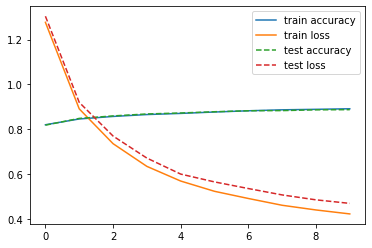

In [58]:
linestyles = {'train': '-', 'test': '--'}
for split in ['train', 'test']:
    for metric in ['accuracy', 'loss']:
        plt.plot(results['epoch'], results[split][metric], ls=linestyles[split], label=f"{split} {metric}")
        
plt.legend()
plt.show()

## Reapply above with a parameter search using scikit-optimize

To do a hyperparameter search, create a model generation wrapper and an objective function.  The objective function must accept this iteration's parameters and do everything required to train and evaluate.  If you want to cross validate, train on some data and test on other, etc., it is done in objective.  Objective should return the value to be minimized

Define the hyperparameter space and model generator

In [70]:
hyperparameter_specs = [
    Real(0.0, 0.75, name='dropout'),
    Integer(1, 7, name='n_layers'),
    Integer(500, 5000, name='max_steps'),
    ]

Here we use a classifier with n 64-node layers and variable dropout, just for testing the hp search

In [71]:
def create_model(n_layers=3, dropout=0.0, cache_dir=None):
    if not cache_dir:
        cache_dir = tempfile.mkdtemp(dir="./")
    print(f"Model cache_dir = {cache_dir}")

    # Using a premade classifier also sets things like the model_fn's scoring methods.  Like below when we do model.evaluate we get accuracy and loss

    model = tf.estimator.DNNClassifier(
        [64] * n_layers,
        feature_columns=feature_columns,
        model_dir=cache_dir,
        n_classes=10,  # How to infer this?
        dropout=dropout,
    )
    return model

Use the use_named_args wrapper to translate params from the optimizer (which passes them as an unnamed tuple) into kwargs

In [83]:
@use_named_args(hyperparameter_specs)
def objective(return_model=False, **hp_config):
    
    with tempfile.TemporaryDirectory(dir="./") as tmpdir:
        model = create_model(hp_config['n_layers'], hp_config['dropout'], cache_dir=tmpdir)

        train_spec = tf.estimator.TrainSpec(input_fn=lambda: input_fn("train"), max_steps=hp_config['max_steps'])
        eval_spec = tf.estimator.EvalSpec(input_fn=lambda: input_fn("test"))
        res = tf.estimator.train_and_evaluate(model, train_spec, eval_spec)
    
    print(res[0])
    if return_model:
        return res[0]['loss'], model
    else:
        return res[0]['loss']

In [75]:
res = gp_minimize(
    objective,
    dimensions=hyperparameter_specs,
    n_calls=50,
    random_state=42,
    n_jobs=4,
)

Model cache_dir = ./tmp_95k8ux6
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp_95k8ux6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and e

/home/scribs/code_not_git/tf_estimators/venv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./tmpfygq8hg4/model.ckpt.
INFO:tensorflow:loss = 39.453556, step = 0
INFO:tensorflow:global_step/sec: 211.707
INFO:tensorflow:loss = 2.4416363, step = 100 (0.474 sec)
INFO:tensorflow:global_step/sec: 209.196
INFO:tensorflow:loss = 1.8010094, step = 200 (0.477 sec)
INFO:tensorflow:global_step/sec: 255.089
INFO:tensorflow:loss = 1.4801841, step = 300 (0.392 sec)
INFO:tensorflow:global_step/sec: 257.928
INFO:tensorflow:loss = 2.108869, step = 400 (0.388 sec)
INFO:tensorflow:global_step/sec: 259.799
INFO:tensorflow:loss = 1.6221915, step = 500 (0.384 sec)
INFO:tensorflow:global_step/sec: 214.953
INFO:tensorflow:loss = 1.1097294, step = 600 (0.465 sec)
INFO:tensorflow:global_step/sec: 223.587
INFO:tensorflow:loss = 1.0136199, step = 700 (0.447 se

/home/scribs/code_not_git/tf_estimators/venv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./tmpjwjdy1zh/model.ckpt.
INFO:tensorflow:loss = 20.94984, step = 0
INFO:tensorflow:global_step/sec: 191.065
INFO:tensorflow:loss = 1.3956785, step = 100 (0.524 sec)
INFO:tensorflow:global_step/sec: 203.017
INFO:tensorflow:loss = 1.8444921, step = 200 (0.506 sec)
INFO:tensorflow:global_step/sec: 225.158
INFO:tensorflow:loss = 0.8566415, step = 300 (0.431 sec)
INFO:tensorflow:global_step/sec: 241.655
INFO:tensorflow:loss = 1.3246853, step = 400 (0.413 sec)
INFO:tensorflow:global_step/sec: 261.495
INFO:tensorflow:loss = 0.8830876, step = 500 (0.384 sec)
INFO:tensorflow:global_step/sec: 246.142
INFO:tensorflow:loss = 0.86846143, step = 600 (0.407 sec)
INFO:tensorflow:global_step/sec: 276.837
INFO:tensorflow:loss = 0.39376685, step = 700 (0.364 

/home/scribs/code_not_git/tf_estimators/venv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./tmp7lkcwtjq/model.ckpt.
INFO:tensorflow:loss = 18.847282, step = 0
INFO:tensorflow:global_step/sec: 246.648
INFO:tensorflow:loss = 1.8160307, step = 100 (0.427 sec)
INFO:tensorflow:global_step/sec: 271.445
INFO:tensorflow:loss = 1.5219955, step = 200 (0.349 sec)
INFO:tensorflow:global_step/sec: 286.2
INFO:tensorflow:loss = 1.6096737, step = 300 (0.348 sec)
INFO:tensorflow:global_step/sec: 279.491
INFO:tensorflow:loss = 1.2523599, step = 400 (0.358 sec)
INFO:tensorflow:global_step/sec: 274.086
INFO:tensorflow:loss = 1.0352066, step = 500 (0.365 sec)
INFO:tensorflow:global_step/sec: 244.286
INFO:tensorflow:loss = 1.3693244, step = 600 (0.409 sec)
INFO:tensorflow:global_step/sec: 229.532
INFO:tensorflow:loss 

/home/scribs/code_not_git/tf_estimators/venv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./tmpfqemi9ze/model.ckpt.
INFO:tensorflow:loss = 14.879376, step = 0
INFO:tensorflow:global_step/sec: 204.669
INFO:tensorflow:loss = 1.8480753, step = 100 (0.493 sec)
INFO:tensorflow:global_step/sec: 228.362
INFO:tensorflow:loss = 1.5542004, step = 200 (0.435 sec)
INFO:tensorflow:global_step/sec: 252.584
INFO:tensorflow:loss = 1.1773946, step = 300 (0.396 sec)
INFO:tensorflow:global_step/sec: 212.429
INFO:tensorflow:loss = 1.7580421, step = 400 (0.472 sec)
INFO:tensorflow:global_step/sec: 268.773
INFO:tensorflow:loss = 1.3019197, step = 500 (0.370 sec)
INFO:tensorflow:global_step/sec: 299.697
INFO:tensorflow:loss = 1.1139159, step = 600 (0.335 sec)
INFO:tensorflow:global_step/sec: 279.359
INFO:tensorflow:loss = 1.5070109, step = 700 (0.358 s

/home/scribs/code_not_git/tf_estimators/venv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./tmp28yq216i/model.ckpt.
INFO:tensorflow:loss = 18.331163, step = 0
INFO:tensorflow:global_step/sec: 266.173
INFO:tensorflow:loss = 1.961539, step = 100 (0.377 sec)
INFO:tensorflow:global_step/sec: 305.924
INFO:tensorflow:loss = 1.5660365, step = 200 (0.327 sec)
INFO:tensorflow:global_step/sec: 304.519
INFO:tensorflow:loss = 1.3476403, step = 300 (0.330 sec)
INFO:tensorflow:global_step/sec: 286.377
INFO:tensorflow:loss = 1.3209773, step = 400 (0.348 sec)
INFO:tensorflow:global_step/sec: 296.457
INFO:tensorflow:loss = 1.2201915, step = 500 (0.337 sec)
INFO:tensorflow:global_step/sec: 288.858
INFO:tensorflow:loss = 1.1459045, step = 600 (0.346 sec)
INFO:tensorflow:global_step/sec: 326.575
INFO:tensorflow:loss = 0.7073257, step = 700 (0.306 se

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f6a3abb50>,
      dtype=object)

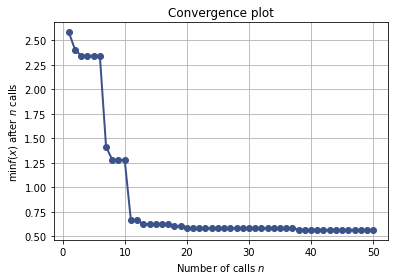

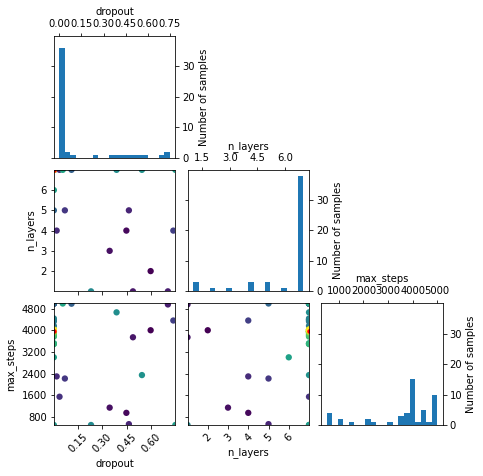

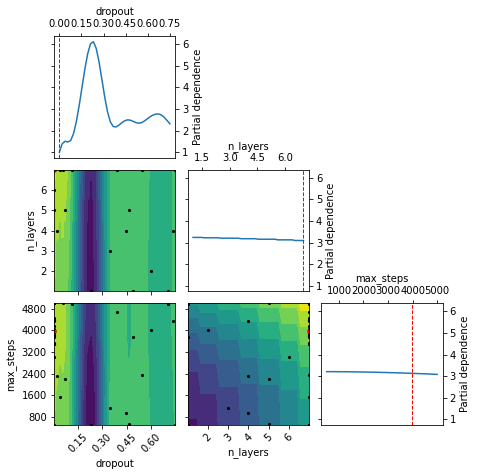

In [78]:
plot_convergence(res)
plot_evaluations(res)
plot_objective(res)

Rerun this model again for fun...


In [188]:
objective(res.x)

Model cache_dir = ./tmpjmnc2nd9
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmpjmnc2nd9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and e

0.68737257

# Save the model for later serving

Used this guide: https://www.tensorflow.org/guide/saved_model

Guide mentions that "tf.estimator.export.build_raw_serving_input_receiver_fn allows you to create input functions which take raw tensors rather than tf.train.Examples."

Seems like we set up the saved model to accept a more raw form of inputs.  But that means when we call the models, we also need to form inputs in that raw way...

In [92]:
@use_named_args(hyperparameter_specs)
def train_final(return_model=True, **hp_config):
    """Train with a durable tmpdir so the model can be exported later"""
    
    tmpdir = tempfile.mkdtemp(dir="./")
    model = create_model(hp_config['n_layers'], hp_config['dropout'], cache_dir=tmpdir)

    train_spec = tf.estimator.TrainSpec(input_fn=lambda: input_fn("train"), max_steps=hp_config['max_steps'])
    eval_spec = tf.estimator.EvalSpec(input_fn=lambda: input_fn("test"))
    res = tf.estimator.train_and_evaluate(model, train_spec, eval_spec)
    
    print(res[0])
    if return_model:
        return res[0]['loss'], model
    else:
        return res[0]['loss']

In [93]:
loss, model = train_final(res.x)

Model cache_dir = ./tmpt2wgakrw
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmpt2wgakrw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and e

As per [here](https://www.tensorflow.org/guide/saved_model)

Notes about serving.  

We make an `example_spec` with `tf.feature_column.make_parse_example_spec`, where an `example_spec` is a dict of name:FixedLenFeature entries that define how input should look.  Then we make a `serving_input_receiver_fn` using `tf.estimator.export.build_parsing_serving_input_receiver_fn`.  This resulting `serving_input_receiver_fn` is a function that takes a serialized `tf.Example` (eg: `example.SerializeToString()`, or maybe `tf.constant(\[example.SerializeToString()\])`?) as input and converts it as per the `example_spec`.  

To make use of all this with an imported saved model (`imported = tf.saved_model.load(path)`) we would invoke it with `imported.signatures['predict'](examples=mySerializedExample)` 

So I need to figure out how to describe a 28x28 image as a serialized tf.Example.

In [149]:
# Slightly different method discussed here:
# https://medium.com/@yuu.ishikawa/serving-pre-modeled-and-custom-tensorflow-estimator-with-tensorflow-serving-12833b4be421
export_path = "./saved_model"
As per [here](https://www.tensorflow.org/guide/saved_model)

Notes about serving.  

We make an `example_spec` with `tf.feature_column.make_parse_example_spec`, where an `example_spec` is a dict of name:FixedLenFeature entries that define how input should look.  Then we make a `serving_input_receiver_fn` using `tf.estimator.export.build_parsing_serving_input_receiver_fn`.  This resulting `serving_input_receiver_fn` is a function that takes a serialized `tf.Example` (eg: `example.SerializeToString()`, or maybe `tf.constant(\[example.SerializeToString()\])`?) as input and converts it as per the `example_spec`.  

To make use of all this with an imported saved model (`imported = tf.saved_model.load(path)`) we would invoke it with `imported.signatures['predict'](examples=mySerializedExample)` 

So I need to figure out how to describe a 28x28 image as a serialized tf.Example.input_receiver_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
    tf.feature_column.make_parse_example_spec(feature_columns)
)
model.export_saved_model(
    export_path, 
    serving_input_receiver_fn,
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from ./tmpt2wgakrw/model.ckpt-1875
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./saved_model/temp-b'1585591410'/saved_model.pb


b'./saved_model/1585591410'

And to reuse the model...

In [151]:
imported = tf.saved_model.load(export_path + "/1585591410")
DEFAULT_FUNCTION_KEY = "serving_default"
inference_func = imported.signatures[DEFAULT_FUNCTION_KEY]

In [189]:
list(imported.signatures.keys())

['serving_default', 'predict', 'classification']

In [178]:
# Get just the image feature (tensor) from ds
ds_image_only = ds.map(lambda image, label: image['image'])

In [190]:
ds_image_only

<DatasetV1Adapter shapes: (None, 28, 28, 1), types: tf.uint8>

**This next step does not work as I'm passing a 28x28x1 tensor of an image whereas the inference_func expects something else**.  From some reading I think it expects a string-serialized version of a tf.Example of the input tensor, or maybe of the input tensor as a string?  It wasn't clear.  Not sure why but the structured_input_signature feels wrong...

In [195]:
print(inference_func.structured_input_signature)

None


In [187]:
# Does not work
for batch in ds_image_only.take(1):
    inference_func(batch)

InvalidArgumentError: cannot compute __inference_pruned_663899 as input #0(zero-based) was expected to be a string tensor but is a uint8 tensor [Op:__inference_pruned_663899]

Started playing with tf.train.Example to figure out how to do above, but got caught with the dimensions of the image input.  I think we need a byte string representing the numpy (so something like numpy.tostring then to tf bytestring)?

In [98]:
example = tf.train.Example()

In [143]:
example.features.feature['image'].float_list.value.extend([this_image.tolist()])
imported.signatures["predict"](
    examples=tf.constant([example.SerializeToString()]),
)

TypeError: [[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0] has type list, but expected one of: int, long, float

In [146]:
example.features.feature['image'].float_list.value.extend(this_image.tolist())

TypeError: [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], has type list, but expected one of: int, long, float

# TO READ

In [ ]:
# https://medium.com/@yuu.ishikawa/serving-pre-modeled-and-custom-tensorflow-estimator-with-tensorflow-serving-12833b4be421
# Mentions there's helper functions to make input_fn from other data.  In this case, train_data and y are numpy arrays
# I think thought it is deprecated and is now here? https://www.tensorflow.org/api_docs/python/tf/compat/v1/estimator/inputs/numpy_input_fn
# Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={INPUT_FEATURE: train_data},
        y=train_labels,
        batch_size=100,
        num_epochs=None,
        shuffle=True)
    classifier.train(input_fn=train_input_fn, steps=FLAGS.steps)


# Further notes: